<a href="https://colab.research.google.com/github/mohmadAyman75/Face-classification/blob/main/FINAL_VGG16_50Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split


Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Final_data"

train  train-20251212T212831Z-1-001.zip  val  val-20251212T224639Z-1-001.zip


In [4]:
import zipfile
import os

base_path = "/content/drive/MyDrive/Final_data"

zip_train = os.path.join(base_path, "train-20251212T212831Z-1-001.zip")
zip_val   = os.path.join(base_path, "val-20251212T224639Z-1-001.zip")

extract_train = os.path.join(base_path, "train")
extract_val   = os.path.join(base_path, "val")

# فك ضغط train
if not os.path.exists(extract_train):
    with zipfile.ZipFile(zip_train, 'r') as zip_ref:
        zip_ref.extractall(extract_train)

# فك ضغط val
if not os.path.exists(extract_val):
    with zipfile.ZipFile(zip_val, 'r') as zip_ref:
        zip_ref.extractall(extract_val)

print("Unzip done")


Unzip done


In [5]:
print(os.listdir("/content/drive/MyDrive/Final_data"))
print(os.listdir("/content/drive/MyDrive/Final_data/train"))
print(os.listdir("/content/drive/MyDrive/Final_data/val"))


['train-20251212T212831Z-1-001.zip', 'val-20251212T224639Z-1-001.zip', 'train', 'val']
['train']
['val']


In [6]:
train_path_data = "/content/drive/MyDrive/Final_data/train/train"
val_path_data   = "/content/drive/MyDrive/Final_data/val/val"


In [7]:
print(os.listdir(train_path_data)[:5])
print(os.listdir(val_path_data)[:5])


['n000437', 'Mohamed_eissa', '1Mohmad-Ayman-Suleiman', 'n000479', 'n000433']
['n001125', 'n000836', 'n001197', 'n001021', 'n000774']


In [8]:
def natural_sort_key(text):
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', text)]

def generate_df(dir_path, limit_per_class=None):
    image_path = []
    image_label = []

    for label in sorted(os.listdir(dir_path), key=natural_sort_key):
        label_path = os.path.join(dir_path, label)
        if not os.path.isdir(label_path):
            continue

        images = sorted(os.listdir(label_path), key=natural_sort_key)
        if limit_per_class:
            images = images[:limit_per_class]

        for img in images:
            full_path = os.path.join(label_path, img)
            if os.path.isfile(full_path):
                image_path.append(full_path)
                image_label.append(label)

    return pd.DataFrame({
        "image_path": image_path,
        "label": image_label
    })


In [9]:
train_df = generate_df(train_path_data, limit_per_class=50)
val_df   = generate_df(val_path_data, limit_per_class=50)

train_df = pd.concat([train_df, val_df], ignore_index=True).reset_index(drop=True)
MAX_CLASSES = 50
selected_labels = sorted(train_df['label'].unique())[:MAX_CLASSES]
train_df = train_df[train_df['label'].isin(selected_labels)].reset_index(drop=True)

class_idx = {label: i for i, label in enumerate(sorted(train_df['label'].unique()))}
train_df['label_'] = train_df['label'].map(class_idx)

NUM_CLASSES = train_df['label_'].nunique()
print("Num of classes:", NUM_CLASSES)
with open("class mapping.json", "w") as f:
    json.dump({v: k for k, v in class_idx.items()}, f)


Num of classes: 50


In [10]:
train_df_split, val_df_split = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label_'],
    random_state=42
)

train_df_split['label_'] = train_df_split['label_'].astype(str)
val_df_split['label_']   = val_df_split['label_'].astype(str)

print(len(train_df_split), len(val_df_split))


2000 500


In [11]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 45

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df_split,
    x_col='image_path',
    y_col='label_',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df_split,
    x_col='image_path',
    y_col='label_',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)


Found 1997 validated image filenames belonging to 50 classes.
Found 499 validated image filenames belonging to 50 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [12]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        51,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,291,250 (58.33 MB)

 Trainable params: 576,562 (2.20 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_vgg16_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop, checkpoint]
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.0260 - loss: 7.6188 
Epoch 1: val_loss improved from inf to 4.43419, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 930s 28s/step - accuracy: 0.0262 - loss: 7.6015 - val_accuracy: 0.0461 - val_loss: 4.4342 - learning_rate: 1.0000e-04
Epoch 2/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0426 - loss: 5.8674
Epoch 2: val_loss improved from 4.43419 to 3.66979, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.0429 - loss: 5.8588 - val_accuracy: 0.1263 - val_loss: 3.6698 - learning_rate: 1.0000e-04
Epoch 3/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0872 - loss: 4.7228
Epoch 3: val_loss improved from 3.66979 to 3.19491, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0873 - loss: 4.7201 - val_accuracy: 0.1984 - val_loss: 3.1949 - learning_rate: 1.0000e-04
Epoch 4/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1115 - loss: 4.0985
Epoch 4: val_loss improved from 3.19491 to 2.86434, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.1119 - loss: 4.0958 - val_accuracy: 0.2645 - val_loss: 2.8643 - learning_rate: 1.0000e-04
Epoch 5/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1671 - loss: 3.6338
Epoch 5: val_loss improved from 2.86434 to 2.62912, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.1675 - loss: 3.6319 - val_accuracy: 0.3267 - val_loss: 2.6291 - learning_rate: 1.0000e-04
Epoch 6/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2156 - loss: 3.3433
Epoch 6: val_loss improved from 2.62912 to 2.45100, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2159 - loss: 3.3410 - val_accuracy: 0.3687 - val_loss: 2.4510 - learning_rate: 1.0000e-04
Epoch 7/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2429 - loss: 3.0604
Epoch 7: val_loss improved from 2.45100 to 2.31847, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2436 - loss: 3.0582 - val_accuracy: 0.3788 - val_loss: 2.3185 - learning_rate: 1.0000e-04
Epoch 8/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2675 - loss: 2.9186
Epoch 8: val_loss improved from 2.31847 to 2.20372, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2680 - loss: 2.9151 - val_accuracy: 0.4228 - val_loss: 2.2037 - learning_rate: 1.0000e-04
Epoch 9/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2994 - loss: 2.6722
Epoch 9: val_loss improved from 2.20372 to 2.11051, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2999 - loss: 2.6712 - val_accuracy: 0.4409 - val_loss: 2.1105 - learning_rate: 1.0000e-04
Epoch 10/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3191 - loss: 2.5980
Epoch 10: val_loss improved from 2.11051 to 2.01040, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3196 - loss: 2.5954 - val_accuracy: 0.4629 - val_loss: 2.0104 - learning_rate: 1.0000e-04
Epoch 11/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3622 - loss: 2.3654
Epoch 11: val_loss improved from 2.01040 to 1.94161, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3625 - loss: 2.3652 - val_accuracy: 0.4950 - val_loss: 1.9416 - learning_rate: 1.0000e-04
Epoch 12/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3736 - loss: 2.2831
Epoch 12: val_loss improved from 1.94161 to 1.86783, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3740 - loss: 2.2816 - val_accuracy: 0.5150 - val_loss: 1.8678 - learning_rate: 1.0000e-04
Epoch 13/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4080 - loss: 2.1075
Epoch 13: val_loss improved from 1.86783 to 1.81199, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4082 - loss: 2.1081 - val_accuracy: 0.5351 - val_loss: 1.8120 - learning_rate: 1.0000e-04
Epoch 14/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4009 - loss: 2.0856
Epoch 14: val_loss improved from 1.81199 to 1.76247, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4012 - loss: 2.0860 - val_accuracy: 0.5371 - val_loss: 1.7625 - learning_rate: 1.0000e-04
Epoch 15/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4375 - loss: 1.9770
Epoch 15: val_loss improved from 1.76247 to 1.71178, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4378 - loss: 1.9774 - val_accuracy: 0.5511 - val_loss: 1.7118 - learning_rate: 1.0000e-04
Epoch 16/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4883 - loss: 1.8531
Epoch 16: val_loss improved from 1.71178 to 1.66015, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4880 - loss: 1.8537 - val_accuracy: 0.5511 - val_loss: 1.6602 - learning_rate: 1.0000e-04
Epoch 17/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4991 - loss: 1.8092
Epoch 17: val_loss improved from 1.66015 to 1.60709, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4990 - loss: 1.8100 - val_accuracy: 0.5711 - val_loss: 1.6071 - learning_rate: 1.0000e-04
Epoch 18/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5083 - loss: 1.7248
Epoch 18: val_loss improved from 1.60709 to 1.57550, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5083 - loss: 1.7252 - val_accuracy: 0.5832 - val_loss: 1.5755 - learning_rate: 1.0000e-04
Epoch 19/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5156 - loss: 1.7559
Epoch 19: val_loss improved from 1.57550 to 1.54315, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5159 - loss: 1.7540 - val_accuracy: 0.5972 - val_loss: 1.5432 - learning_rate: 1.0000e-04
Epoch 20/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5448 - loss: 1.6245
Epoch 20: val_loss improved from 1.54315 to 1.50109, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5448 - loss: 1.6240 - val_accuracy: 0.6092 - val_loss: 1.5011 - learning_rate: 1.0000e-04
Epoch 21/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5594 - loss: 1.6060
Epoch 21: val_loss improved from 1.50109 to 1.48557, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5590 - loss: 1.6063 - val_accuracy: 0.6072 - val_loss: 1.4856 - learning_rate: 1.0000e-04
Epoch 22/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5548 - loss: 1.5325
Epoch 22: val_loss improved from 1.48557 to 1.45196, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5549 - loss: 1.5322 - val_accuracy: 0.6072 - val_loss: 1.4520 - learning_rate: 1.0000e-04
Epoch 23/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5717 - loss: 1.4543
Epoch 23: val_loss improved from 1.45196 to 1.42988, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5719 - loss: 1.4549 - val_accuracy: 0.6273 - val_loss: 1.4299 - learning_rate: 1.0000e-04
Epoch 24/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5921 - loss: 1.4269
Epoch 24: val_loss improved from 1.42988 to 1.42725, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5914 - loss: 1.4284 - val_accuracy: 0.6313 - val_loss: 1.4273 - learning_rate: 1.0000e-04
Epoch 25/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6088 - loss: 1.3582
Epoch 25: val_loss improved from 1.42725 to 1.39705, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6085 - loss: 1.3581 - val_accuracy: 0.6313 - val_loss: 1.3970 - learning_rate: 1.0000e-04
Epoch 26/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6007 - loss: 1.4007
Epoch 26: val_loss improved from 1.39705 to 1.37114, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6011 - loss: 1.3994 - val_accuracy: 0.6313 - val_loss: 1.3711 - learning_rate: 1.0000e-04
Epoch 27/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6407 - loss: 1.2897
Epoch 27: val_loss improved from 1.37114 to 1.36108, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6405 - loss: 1.2896 - val_accuracy: 0.6232 - val_loss: 1.3611 - learning_rate: 1.0000e-04
Epoch 28/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6761 - loss: 1.1898
Epoch 28: val_loss improved from 1.36108 to 1.34269, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6750 - loss: 1.1914 - val_accuracy: 0.6393 - val_loss: 1.3427 - learning_rate: 1.0000e-04
Epoch 29/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6366 - loss: 1.2455
Epoch 29: val_loss improved from 1.34269 to 1.32023, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6368 - loss: 1.2457 - val_accuracy: 0.6373 - val_loss: 1.3202 - learning_rate: 1.0000e-04
Epoch 30/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6655 - loss: 1.1761
Epoch 30: val_loss improved from 1.32023 to 1.29594, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6653 - loss: 1.1766 - val_accuracy: 0.6353 - val_loss: 1.2959 - learning_rate: 1.0000e-04
Epoch 31/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6612 - loss: 1.1481
Epoch 31: val_loss improved from 1.29594 to 1.28815, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6614 - loss: 1.1484 - val_accuracy: 0.6493 - val_loss: 1.2882 - learning_rate: 1.0000e-04
Epoch 32/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6695 - loss: 1.1224
Epoch 32: val_loss improved from 1.28815 to 1.27914, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6693 - loss: 1.1227 - val_accuracy: 0.6573 - val_loss: 1.2791 - learning_rate: 1.0000e-04
Epoch 33/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6924 - loss: 1.0873
Epoch 33: val_loss improved from 1.27914 to 1.26471, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6920 - loss: 1.0881 - val_accuracy: 0.6613 - val_loss: 1.2647 - learning_rate: 1.0000e-04
Epoch 34/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6963 - loss: 1.0183
Epoch 34: val_loss improved from 1.26471 to 1.24453, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6963 - loss: 1.0186 - val_accuracy: 0.6513 - val_loss: 1.2445 - learning_rate: 1.0000e-04
Epoch 35/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7193 - loss: 1.0067
Epoch 35: val_loss improved from 1.24453 to 1.22266, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7191 - loss: 1.0073 - val_accuracy: 0.6713 - val_loss: 1.2227 - learning_rate: 1.0000e-04
Epoch 36/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7083 - loss: 0.9586
Epoch 36: val_loss improved from 1.22266 to 1.20531, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7083 - loss: 0.9593 - val_accuracy: 0.6653 - val_loss: 1.2053 - learning_rate: 1.0000e-04
Epoch 37/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7268 - loss: 0.9911
Epoch 37: val_loss improved from 1.20531 to 1.20465, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7264 - loss: 0.9911 - val_accuracy: 0.6733 - val_loss: 1.2046 - learning_rate: 1.0000e-04
Epoch 38/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7296 - loss: 0.9579
Epoch 38: val_loss improved from 1.20465 to 1.19919, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7294 - loss: 0.9576 - val_accuracy: 0.6673 - val_loss: 1.1992 - learning_rate: 1.0000e-04
Epoch 39/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7379 - loss: 0.8815
Epoch 39: val_loss improved from 1.19919 to 1.19187, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7376 - loss: 0.8832 - val_accuracy: 0.6774 - val_loss: 1.1919 - learning_rate: 1.0000e-04
Epoch 40/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6943 - loss: 0.9674
Epoch 40: val_loss improved from 1.19187 to 1.18846, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6951 - loss: 0.9655 - val_accuracy: 0.6673 - val_loss: 1.1885 - learning_rate: 1.0000e-04
Epoch 41/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7213 - loss: 0.9195
Epoch 41: val_loss improved from 1.18846 to 1.17949, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7213 - loss: 0.9189 - val_accuracy: 0.6713 - val_loss: 1.1795 - learning_rate: 1.0000e-04
Epoch 42/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7606 - loss: 0.8514
Epoch 42: val_loss improved from 1.17949 to 1.17137, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7604 - loss: 0.8514 - val_accuracy: 0.6754 - val_loss: 1.1714 - learning_rate: 1.0000e-04
Epoch 43/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7561 - loss: 0.8255
Epoch 43: val_loss improved from 1.17137 to 1.15391, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7559 - loss: 0.8261 - val_accuracy: 0.6854 - val_loss: 1.1539 - learning_rate: 1.0000e-04
Epoch 44/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7828 - loss: 0.7515
Epoch 44: val_loss improved from 1.15391 to 1.14186, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7824 - loss: 0.7528 - val_accuracy: 0.6854 - val_loss: 1.1419 - learning_rate: 1.0000e-04
Epoch 45/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7382 - loss: 0.8323
Epoch 45: val_loss improved from 1.14186 to 1.13795, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7388 - loss: 0.8313 - val_accuracy: 0.6834 - val_loss: 1.1379 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 45.


In [14]:
model = tf.keras.models.load_model("best_vgg16_model.h5")
print("Model loaded successfully")

Model loaded successfully


In [15]:
for layer in model.layers:
    layer.trainable = False
for layer in model.layers:
    if layer.name.startswith("block5"):
        layer.trainable = True
print("\nTrainable layers:")
for layer in model.layers:
    if layer.trainable:
        print(layer.name)



Trainable layers:
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_vgg16_finetuned.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


In [18]:
history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7801 - loss: 0.7556
Epoch 1: val_loss improved from inf to 1.01721, saving model to best_vgg16_finetuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7805 - loss: 0.7538 - val_accuracy: 0.7315 - val_loss: 1.0172 - learning_rate: 1.0000e-05
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7931 - loss: 0.6574
Epoch 2: val_loss improved from 1.01721 to 0.94852, saving model to best_vgg16_finetuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7933 - loss: 0.6564 - val_accuracy: 0.7535 - val_loss: 0.9485 - learning_rate: 1.0000e-05
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8118 - loss: 0.5855
Epoch 3: val_loss did not improve from 0.94852
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8123 - loss: 0.5848 - val_accuracy: 0.7415 - val_loss: 0.9847 - learning_rate: 1.0000e-05
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8253 - loss: 0.5638
Epoch 

In [19]:
model.save("best_vgg16_model.h5")

Available classes: ['17' '16' '41' '29' '25' '35' '1' '0' '24' '27' '14' '46' '18' '10' '9'
 '42' '37' '23' '40' '11' '49' '26' '7' '48' '34' '12' '21' '45' '3' '15'
 '4' '31' '6' '39' '2' '33' '19' '38' '22' '36' '43' '20' '5' '28' '8'
 '44' '30' '32' '13' '47']
Selected image path: /content/drive/MyDrive/Final_data/train/train/n000093/0010_01.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


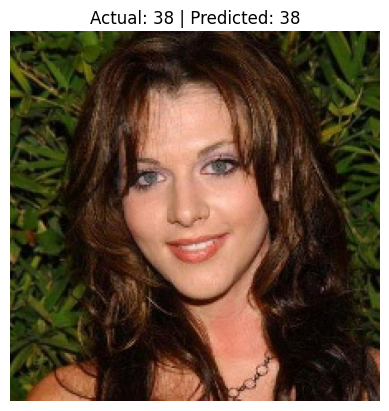

In [37]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# 1️⃣ نجيب كل الكلاسات الموجودة
class_names_list = train_df_split['label_'].unique()
print("Available classes:", class_names_list)

# 2️⃣ نختار كلاس عشوائي أو تحطي اسم الكلاس هنا
selected_class ='38'   # عشوائي
# selected_class = "cat"  # لو حابة تحددي

# 3️⃣ نجيب كل الصور للكلاس ده
img_paths = train_df_split[train_df_split['label_'] == selected_class]['image_path'].tolist()

# 4️⃣ نختار صورة عشوائية
img_path = random.choice(img_paths)
print("Selected image path:", img_path)

# 5️⃣ نحمّل الصورة ونجهزها للـ model
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array_exp = np.expand_dims(img_array, axis=0)
img_array_exp = preprocess_input(img_array_exp)

# 6️⃣ نعمل predict
pred = model.predict(img_array_exp)
pred_class_idx = np.argmax(pred, axis=1)[0]

# 7️⃣ نجهز القاموس للكلاسات
class_names = {v: k for k,v in train_generator.class_indices.items()}

# 8️⃣ نعرض الصورة والنتيجة
import numpy as np

# بدل السطر ده:
# plt.imshow(img.astype('uint8'))

# نعمل تحويل لـ numpy array
plt.imshow(np.array(img).astype('uint8'))
plt.axis('off')
plt.title(f"Actual: {selected_class} | Predicted: {class_names[pred_class_idx]}")
plt.show()


Saving 768457a5-38a3-4b91-b706-5fc58b03e437.jpg to 768457a5-38a3-4b91-b706-5fc58b03e437 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


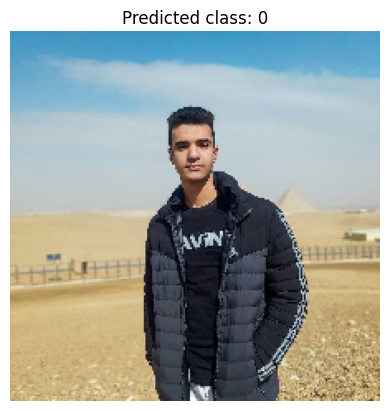

In [47]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array_exp = np.expand_dims(img_array, axis=0)
img_array_exp = preprocess_input(img_array_exp)
pred = model.predict(img_array_exp)
pred_class_idx = np.argmax(pred, axis=1)[0]
class_names_list = sorted(train_df_split['label_'].unique())
class_names = {i: name for i, name in enumerate(class_names_list)}
plt.imshow(np.array(img).astype('uint8'))
plt.axis('off')
plt.title(f"Predicted class: {class_names[pred_class_idx]}")
plt.show()

In [67]:
def predict_top_k(image_path, model, class_idx, k=3):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.applications.vgg16 import preprocess_input
    import numpy as np

    # تحميل الصورة وحجمها المناسب
    img = load_img(image_path, target_size=(224,224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch 1
    img_array = preprocess_input(img_array)        # مهم جدا لـ VGG16

    # التنبؤ
    pred = model.predict(img_array)[0]  # array من الاحتمالات

    # الحصول على top-k indices
    top_indices = pred.argsort()[-k:][::-1]

    # تحويل الرقم لاسم الفئة
    inv_class_idx = {v:k for k,v in class_idx.items()}

    # تجهيز قائمة النتائج
    top_predictions = [(inv_class_idx[i], pred[i]) for i in top_indices]

    return top_predictions


In [65]:
from google.colab import files

# رفع الصورة من جهازك
uploaded = files.upload()

# image_path هياخد اسم أول صورة رفعتها
image_path = list(uploaded.keys())[0]
print("Image uploaded:", image_path)


Saving 768457a5-38a3-4b91-b706-5fc58b03e437.jpg to 768457a5-38a3-4b91-b706-5fc58b03e437 (3).jpg
Image uploaded: 768457a5-38a3-4b91-b706-5fc58b03e437 (3).jpg


In [68]:
top_preds = predict_top_k(image_path, model, class_idx, k=3)
print("Top 3 predictions with probabilities:")
for label, prob in top_preds:
    print(f"{label}: {prob*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Top 3 predictions with probabilities:
1Mohmad-Ayman-Suleiman: 99.90%
n000040: 0.06%
n000067: 0.02%
